# Instance Selection based on Local Sets for Quantum Annealing

In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random as random
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict
from itertools import compress

In [3]:
FOLD = 0
DATASET_NAME = "Yelp"
TEAM_NAME = "gplsi"
SUBMISSIONID = f'2-LocalSets'

RUN_SA = True
RUN_QA = True
NUM_READS = 2000
LIMIT_SIZE = False

In [5]:
import gzip
import numpy as np

with gzip.open(f'data/train{FOLD}.gz', "rb") as fd:
    content = [line.decode('utf-8').strip().split(' ') for line in fd]

num_samples = len(content)
num_features = len(content[0]) - 1

labels = np.empty(num_samples, dtype=int)
features = np.empty((num_samples, num_features), dtype=float)

for i, row in enumerate(content):
    labels[i] = int(row[0])
    for j, feat in enumerate(row[1:]):
        features[i, j] = float(feat.split(':')[1])

X = features
y = labels

print(len(y))
print(y[0:10])
print(len(X))
print(X[0])

3956
[1 1 1 0 0 0 0 1 0 1]
3956
[-0.32730305 -3.1321497   1.70186234 ...  0.97825307 -0.18393582
 -1.62006617]


(3958, 2)
[-34.59432812  -3.21579988]


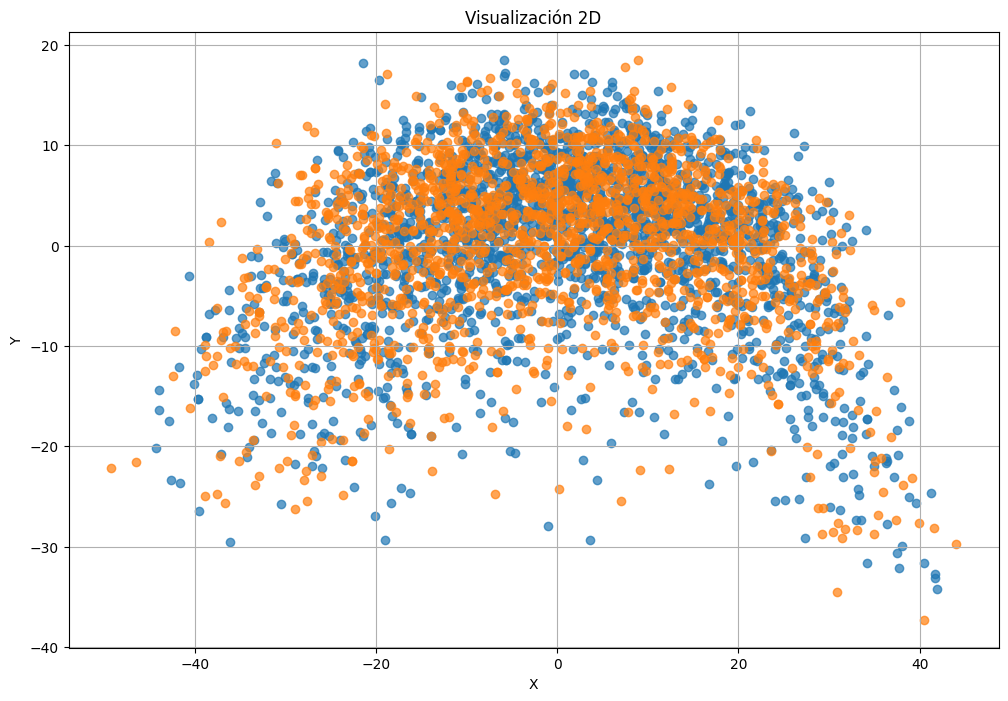

In [179]:
def plot_embs_2d(X, y, kept_indices=None):

    if(kept_indices is None):
        kept_indices = np.arange(len(X), dtype=int) # take all instances
    else:
        kept_indices = np.array(kept_indices)

    # Dimensionality reduction with PCA
    pca = PCA(n_components=2)
    pca.fit(X[kept_indices])
    X_pca = pca.transform(X[kept_indices])
    print(X_pca.shape)
    print(X_pca[0])

    # Plot
    plt.figure(figsize=(12, 8))
    for i in range(2): # 2 classes
        plt.scatter(X_pca[y[kept_indices] == i, 0], X_pca[y[kept_indices] == i, 1], label=f'Class {i}', alpha=0.7)  
        
    plt.title(f"Visualización 2D")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

plot_embs_2d(X, y)

## 1. Noise filtering with the Local Set-based smoother (LSSm)

In [6]:
def ne_dist(labels, distances):
    '''
    Nearest Enemy computation.
    '''
    labels = np.array(labels)
    n = len(labels)
    ne = np.full(n, -1, dtype=int)

    # Create a mask where entries are True if the pair has different labels
    enemy_mask = labels[:, None] != labels[None, :]

    # Set same-class distances to np.inf to ignore them
    masked_distances = np.where(enemy_mask, distances, np.inf)

    # Find the index of the minimum distance in each row
    ne = np.argmin(masked_distances, axis=1)

    return ne

def compute_local_sets(X, y, kept_indices=None):
    '''
    Compute local sets and sort them by increasing Local Set Cardinality (LSC),
    restricted to instances in `kept_indices`.

    Parameters:
    - labels: (n,) full label array
    - ne: (n,) nearest enemy indices in original space
    - distances: (n, n) full pairwise distance matrix
    - kept_indices: list or array of indices to keep (subset of full data)

    Returns:
    - LSs: dict of local sets for each kept index
    - sorted_LSs_dict: dict of kept index → local set (sorted by LSC)
    '''

    if(kept_indices is None):
        kept_indices = np.arange(len(y), dtype=int) # take all instances
    else:
        kept_indices = np.array(kept_indices)

    X_filtered = X[kept_indices]
    y_filtered = y[kept_indices]

    distances_filtered = euclidean_distances(X_filtered, X_filtered)
    NEs_filtered = ne_dist(y_filtered, distances_filtered)
    
    LSs = defaultdict(list)
    lsc_map = []

    for i, real_index in enumerate(kept_indices):
        same_class = (y_filtered == y_filtered[i])
        closer_than_enemy = (distances_filtered[i] <= distances_filtered[i][NEs_filtered[i]])
        mask = same_class & closer_than_enemy
        LS = kept_indices[mask].tolist()

        # Ensure i is included if appropriate
        if real_index not in LS:
            LS.append(real_index)

        LSs[int(real_index)] = LS
        lsc_map.append((int(real_index), len(LS)))

    # Sort by increasing local set size
    lsc_map.sort(key=lambda x: x[1])

    # Create sorted dict
    sorted_LSs_dict = defaultdict(list)
    for i, _ in lsc_map:
        sorted_LSs_dict[int(i)] = LSs[int(i)]

    return LSs, sorted_LSs_dict

def local_set_based_smoother(X, y):
    """
    Local Set Based Smoother (noise filtering).
    
    Keeps points where the number of local sets the point appears in 
    is greater than the number of times it is a nearest enemy.

    Parameters:
    - X: (n_samples, n_features) data array
    - y: (n_samples,) label array
    - ne: (n_samples,) index of nearest enemy for each point
    - distances: (n_samples, n_samples) full pairwise distance matrix

    Returns:
    - kept_indices: indices of retained points (relative to original X)
    """

    n = len(y)
    LSs, _ = compute_local_sets(X, y)
    distances = euclidean_distances(X, X)
    NEs = ne_dist(y, distances)

    # Count how many local sets each point appears in
    usefulness = np.zeros(n, dtype=int)
    for LS in LSs.values():
        for idx in LS:
            usefulness[idx] += 1

    # Count how many times each point is the nearest enemy
    harmfulness = np.zeros(n, dtype=int)
    for enemy in NEs:
        harmfulness[enemy] += 1

    # Apply the smoother condition
    mask = usefulness >= harmfulness
    kept_indices = np.where(mask)[0]
    noise_indices= np.where(np.logical_not(mask))[0]

    return kept_indices, noise_indices


In [7]:
LSs, sorted_LSs_dict = compute_local_sets(X, y)
print(list(LSs.items())[:10])
print()
print(list(sorted_LSs_dict.items())[:10])

[(0, [0]), (1, [1, 2056]), (2, [2]), (3, [3, 2955]), (4, [4, 2985]), (5, [5, 426, 2344, 2601]), (6, [6, 167, 3193, 3482]), (7, [7, 3540]), (8, [8, 1549, 3320, 3912]), (9, [9, 14])]

[(0, [0]), (2, [2]), (11, [11]), (13, [13]), (14, [14]), (15, [15]), (16, [16]), (18, [18]), (22, [22]), (25, [25])]


In [8]:
kept_indices, noise_indices = local_set_based_smoother(X, y)
print(len(kept_indices))
print(len(noise_indices))

3565
391


In [183]:
def plot_noise(X, y, noise_indices):
    num_points = len(X)
    noise_indices = np.array(noise_indices)

    print(f"Noise points: {len(noise_indices)}")

    # PCA projection to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    colors = ['magenta', 'green']  # for 2 classes

    plt.figure(figsize=(12, 8))

    # Plot all points by class
    for i in range(2):  # Assuming 2 classes
        plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=f'Class {i}', alpha=0.3, color=colors[i], s=50)

    # Plot noise points with red crosses
    if len(noise_indices) > 0:
        plt.scatter(X_pca[noise_indices, 0], X_pca[noise_indices, 1],
                    color='red', marker='x', s=50, label='Noise')

    plt.xlabel('PCA-1')
    plt.ylabel('PCA-2')
    plt.title('Noise Points (Projected via PCA)')
    plt.legend()
    plt.grid(True)
    plt.show()

Noise points: 385


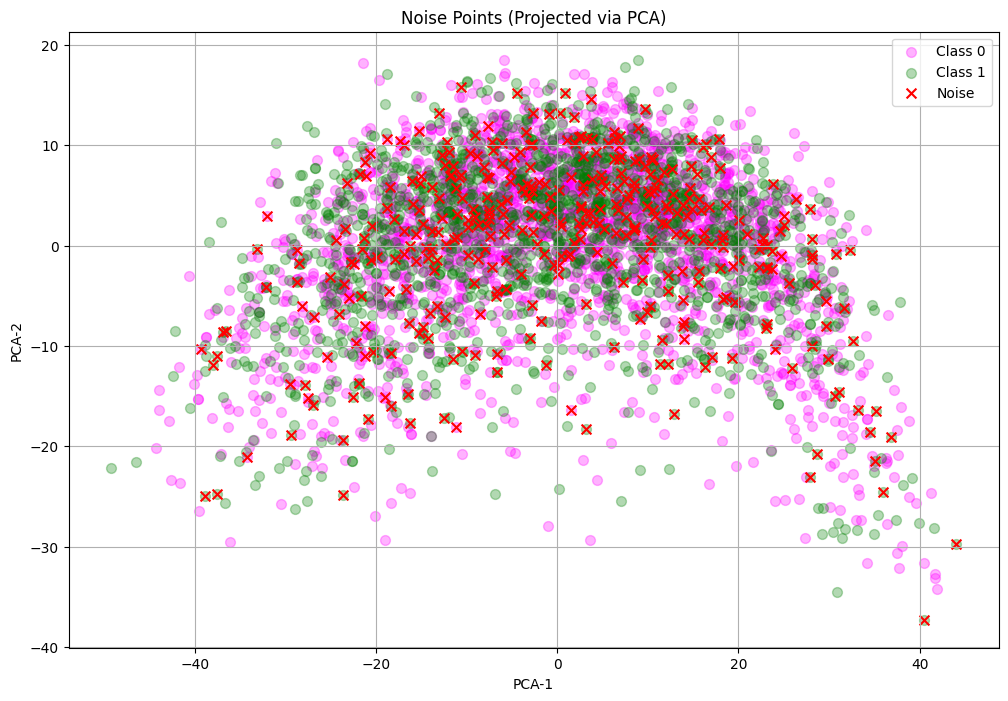

In [184]:
plot_noise(X, y, noise_indices)

## 2. Border detection with the Local Set Border Selector (LSBo)

All border instances are added to the submission set

In [9]:
def local_set_border_selector(X, y, selected_indices):
    """
    Local Set Border Selector
    
    Algorithm to retain border instances. 
    An instance is a border instance if it has the lower LSC among the members of its LS.

    Parameters:
    - X: (n_samples, n_features) data array
    - y: (n_samples,) label array
    - ne: (n_samples,) index of nearest enemy for each point
    - distances: (n_samples, n_samples) full pairwise distance matrix
    - kept_indices: indices of retained points (relative to original X) after noise filtering with LSSm

    Returns:
    - kept_indices: indices of retained points (relative to original X)
    """

    LSs, sorted_LSs_dict = compute_local_sets(X, y, selected_indices)

    borders = set()
    for key, val in sorted_LSs_dict.items():
        LS_members = set(val)
        if len(LS_members.intersection(borders)) == 0:
            borders.add(key)

    borders = list(borders)
    return borders

def plot_borders(X, y, kept_indices, border_indices):
    kept_indices = np.array(kept_indices)
    border_indices = np.array(border_indices)

    X_filtered = X[kept_indices]
    y_filtered = y[kept_indices]

    print(f"Border points: {len(border_indices)}")

    # PCA projection to 2D using only kept instances
    pca = PCA(n_components=2)
    X_pca_all = pca.fit_transform(X)
    X_pca_filtered = X_pca_all[kept_indices]
    
    colors = ['magenta', 'green']  # for 2 classes

    plt.figure(figsize=(12, 8))

    # Plot all filtered points by class
    for i in range(2):  # Assuming 2 classes
        plt.scatter(X_pca_filtered[y_filtered == i, 0],
                    X_pca_filtered[y_filtered == i, 1],
                    label=f'Class {i}', alpha=0.3, color=colors[i], s=50)

    # Plot border points using original indices on full PCA projection
    for i in range(2):
        border_mask = (y == i) & (np.isin(np.arange(len(X)), border_indices))
        plt.scatter(X_pca_all[border_mask, 0],
                    X_pca_all[border_mask, 1],
                    alpha=1, color=colors[i], marker='^', s=50, label=f'Borders Class {i}')

    plt.xlabel('PCA-1')
    plt.ylabel('PCA-2')
    plt.title('Border Points (Projected via PCA)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
borders_lsbo = local_set_border_selector(X, y, kept_indices)

print(len(borders_lsbo))

1832


Border points: 1806


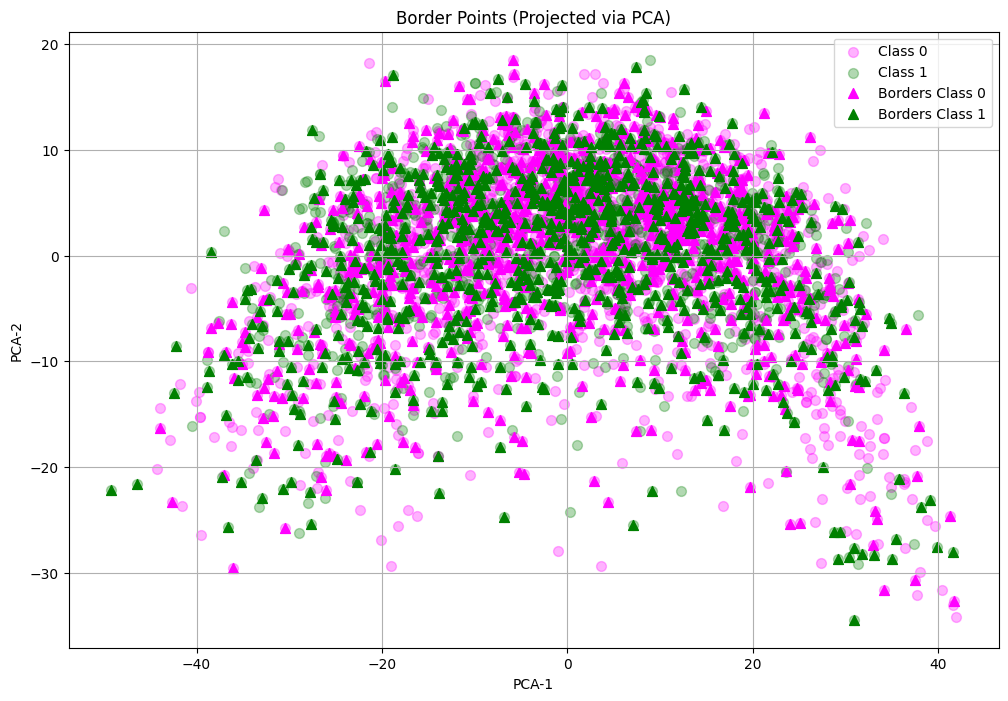

In [187]:
plot_borders(X, y, kept_indices, borders_lsbo)

In [11]:
central_indices = list(set(kept_indices.tolist()).difference(set(borders_lsbo)))
print(len(central_indices))

1733


## 3. Clustering the central (not border) points with Inverse Local Set-Based Clustering

In [12]:
LSs, sorted_LSs_dict = compute_local_sets(X, y, central_indices) 

print(len(LSs))
print(list(LSs.keys())[0:10])
print(list(LSs.values())[0:10])
print()
print(len(sorted_LSs_dict))
print(list(sorted_LSs_dict.keys())[0:10])
print(list(sorted_LSs_dict.values())[0:10])

1733
[0, 6, 8, 9, 10, 12, 13, 17, 19, 20]
[[0, 699, 745, 1396], [6, 112, 155, 167, 236, 485, 563, 881, 882, 1056, 2208, 2238, 2573, 2679, 2957, 3003, 3193, 3482, 3607], [8, 385, 653, 930, 1028, 1119, 1549, 1738, 2195, 2356, 3341, 3912], [9], [10], [12], [13, 1573], [17, 119, 820, 833, 835, 936, 1218, 1290, 1624, 1625, 1699, 1786, 1938, 1999, 2055, 2160, 2237, 2368, 2459, 2616, 2807, 2979, 3582, 3585, 3682, 3704], [19, 326, 359, 835, 1211, 1292, 1699, 1862, 1920, 1982, 1999, 2624, 2917, 2979, 3350, 3582, 3704], [20]]

1733
[9, 10, 12, 20, 46, 81, 85, 93, 103, 130]
[[9], [10], [12], [20], [46], [81], [85], [93], [103], [130]]


In [13]:
def LS_based_clustering_INVERSE(sorted_LSs_dict, LSs): 
    '''
    Inverse Local Set Based Clustering: 
        Assigns each instance to the cluster of the medoid with the smallest local set cardinality that contains it 
        — i.e., inverse local set clustering.
    '''
    clusters = defaultdict(list)
    included_instances = set()

    # Process clusters from lowest to highest LSC
    for LS_key in sorted_LSs_dict.keys():
        if LS_key not in included_instances:
            cluster_instances = set(LSs[LS_key]) - included_instances
            included_instances.update(cluster_instances)
            clusters[LS_key] = list(cluster_instances)

    return clusters

def plot_clusters(clusters, X, y):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot each cluster with random color
    for key, values in clusters.items():
        # Generate random color for cluster
        color = (random.random(), random.random(), random.random())

        # Plot points in cluster
        for value in values:
            plt.scatter(X_pca[value, 0], X_pca[value, 1], color=color, s=150, alpha=0.7)


    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.title("Clusters (High-Dimensional Embeddings Projected to 2D)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
clusters_inverse = LS_based_clustering_INVERSE(sorted_LSs_dict, LSs)
print(len(clusters_inverse))
print(list(clusters_inverse.items())[:10])

1031
[(9, [9]), (10, [10]), (12, [12]), (20, [20]), (46, [46]), (81, [81]), (85, [85]), (93, [93]), (103, [103]), (130, [130])]


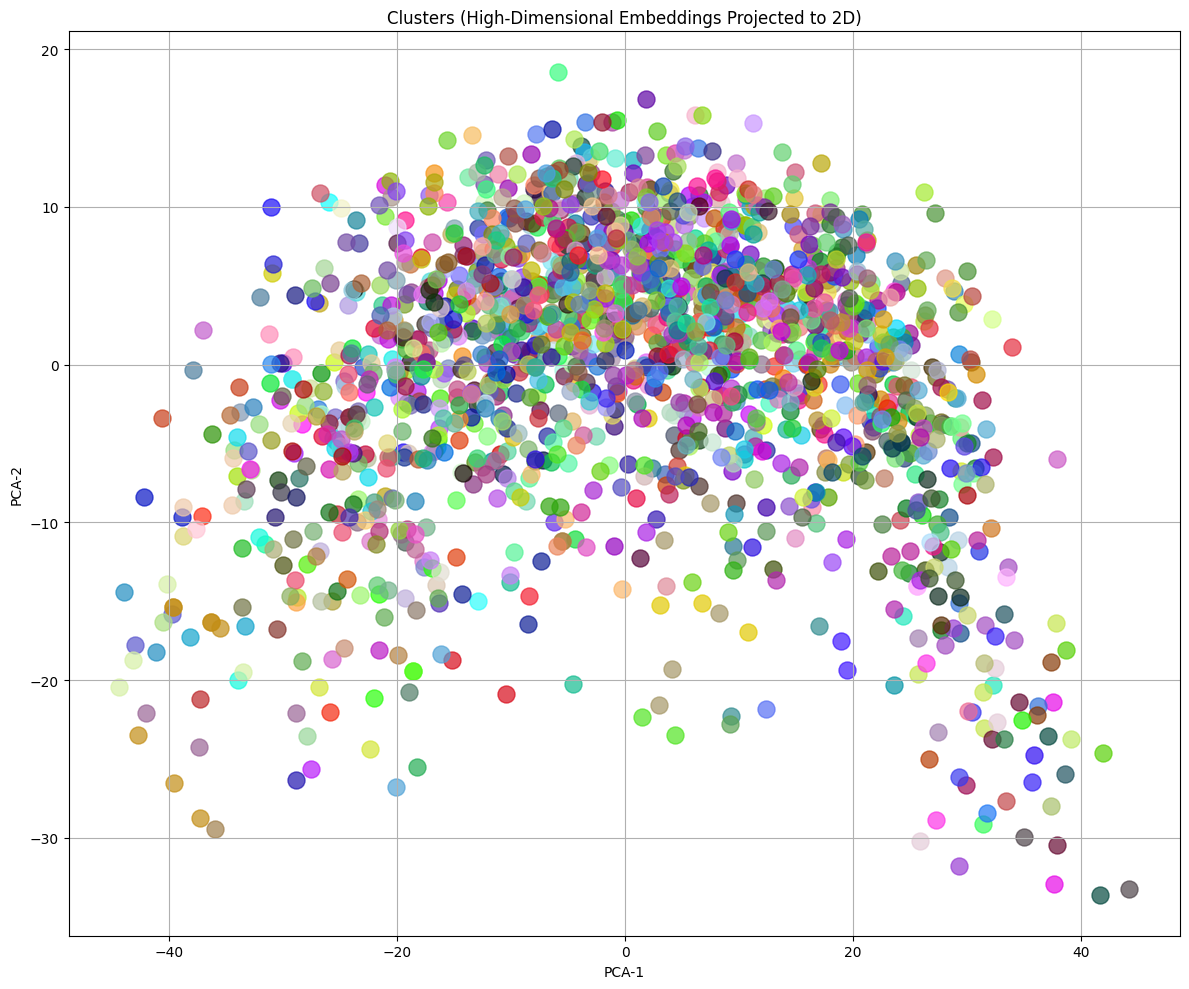

In [15]:
plot_clusters(clusters_inverse, X, y)

## 4. Preselecting 150 clusters based on the distance from each cluster centroid to its nearest border

In [34]:
def compute_centroids(clusters, X):
    centroids = {}
    for cluster_id, indices in clusters.items():
        if indices:  # avoid division by zero
            centroids[cluster_id] = np.mean(X[indices], axis=0)
        else:
            centroids[cluster_id] = np.zeros(X.shape[1])  # or handle empty case differently
    return centroids

def compute_centroid_border_distances(centroids, X, y, borders):
 
    class_to_borders = defaultdict(list)
    class_to_vectors = defaultdict(list)
    for idx in borders:
        class_to_borders[y[idx]].append(idx)
        class_to_vectors[y[idx]].append(X[idx])

    for cls in class_to_vectors:
        class_to_vectors[cls] = np.vstack(class_to_vectors[cls])

    distances = {}
    nearest_borders = {}

    for cluster_id, centroid in centroids.items():
        cls = y[cluster_id]
        border_ids = class_to_borders.get(cls, [])
        border_vecs = class_to_vectors.get(cls, None)

        if border_vecs is None or len(border_ids) == 0:
            distances[cluster_id] = np.inf
            nearest_borders[cluster_id] = None
        else:
            dists = euclidean_distances(centroid.reshape(1, -1), border_vecs).flatten()
            min_idx = np.argmin(dists)
            distances[cluster_id] = dists[min_idx]
            nearest_borders[cluster_id] = border_ids[min_idx]

    return distances, nearest_borders

def compute_centroid_border_distances_v2(centroids, X, y, borders):

    nearest_borders = {}

    for cluster_id, centroid in centroids.items():
        cls = y[cluster_id]
        min_dist = np.inf
        for border_idx in borders:
            if y[border_idx] != cls: continue
            dist = np.linalg.norm(centroid - X[border_idx]) 
            if dist < min_dist:
                min_dist = dist
                nearest_borders[cluster_id] = border_idx
    

    return nearest_borders

def compute_centroid_border_distances_v3(centroids, X, y, borders):
 
    class_to_borders = defaultdict(list)

    for idx in borders:
        class_to_borders[y[idx]].append(idx)

    class_to_vectors = {
        cls: X[indices] for cls, indices in class_to_borders.items()
    }

    nearest_borders = {}

    for cluster_id, centroid in centroids.items():
        cls = y[cluster_id]
        border_ids = class_to_borders.get(cls)
        border_vecs = class_to_vectors.get(cls)

        if not border_ids or border_vecs is None:
            nearest_borders[cluster_id] = None
            continue

        dists = euclidean_distances([centroid], border_vecs).flatten()
        nearest_borders[cluster_id] = border_ids[np.argmin(dists)]

    return nearest_borders

In [17]:
candidate_clusters = clusters_inverse
print(len(candidate_clusters))
centroids = compute_centroids(candidate_clusters, X)
print(list(centroids.items())[:10])

1031
[(9, array([-0.84400749, -1.09614944,  2.08669484, ...,  0.72089481,
       -0.40001678, -0.06367826], shape=(4096,))), (10, array([-3.02293587, -0.89124489,  0.85134161, ...,  1.38591361,
       -0.51424408,  1.82739878], shape=(4096,))), (12, array([-1.8203125 , -1.89338684,  1.97659302, ...,  1.65884209,
        0.11465126,  0.31450844], shape=(4096,))), (20, array([-1.48865604, -0.80876923,  1.38573074, ...,  1.42014313,
        0.36022675,  0.44178987], shape=(4096,))), (46, array([-0.36909246, -2.63053513,  2.63849449, ...,  1.50041389,
       -0.95027256, -0.92620897], shape=(4096,))), (81, array([-0.7335515 , -2.27927589,  2.97392654, ...,  1.08492184,
        0.29240084,  0.33124924], shape=(4096,))), (85, array([-0.69239545, -3.61673951,  1.54438782, ...,  0.94665813,
       -0.55222124, -1.38818121], shape=(4096,))), (93, array([-1.24901247, -1.51819611,  2.38372421, ...,  1.19242096,
       -0.01255059,  0.74253631], shape=(4096,))), (103, array([-1.72649574, -1.776973

In [18]:
%%time

border_dists, nearest_borders = compute_centroid_border_distances(centroids, X, y, borders_lsbo)
for cluster_id, dist in list(border_dists.items())[:10]:
    print(f"Cluster {cluster_id}: Nearest same-class border distance = {dist:.4f}")

print()
print(list(nearest_borders)[:10])

Cluster 9: Nearest same-class border distance = 30.4626
Cluster 10: Nearest same-class border distance = 32.0894
Cluster 12: Nearest same-class border distance = 26.8819
Cluster 20: Nearest same-class border distance = 31.3926
Cluster 46: Nearest same-class border distance = 25.0203
Cluster 81: Nearest same-class border distance = 34.9608
Cluster 85: Nearest same-class border distance = 29.6782
Cluster 93: Nearest same-class border distance = 25.5217
Cluster 103: Nearest same-class border distance = 28.3249
Cluster 130: Nearest same-class border distance = 27.5600

[9, 10, 12, 20, 46, 81, 85, 93, 103, 130]
CPU times: total: 29.1 s
Wall time: 26.6 s


In [35]:
print(centroids[9])
print(X[borders_lsbo[0]])
print(len(centroids[9]))
print(len(X[borders_lsbo[0]]))
print(np.linalg.norm(centroids[9] - X[borders_lsbo[0]])) 
# the norm (or magnitude) of a vector in the case of the difference between two points gives us the Euclidean distance

[-0.84400749 -1.09614944  2.08669484 ...  0.72089481 -0.40001678
 -0.06367826]
[-0.88396335 -1.9474721   2.5859375  ...  0.46487188 -0.53671646
 -0.5849793 ]
4096
4096
40.90224596700124


In [36]:
%%time

nearest_borders = compute_centroid_border_distances_v3(centroids, X, y, borders_lsbo)
for cluster_id, nearest_border in list(nearest_borders.items())[:10]:
    dist = np.linalg.norm(centroids[cluster_id] -  X[nearest_border])
    print(f"Cluster {cluster_id}: Nearest same-class border distance = {dist:.4f}")

print()
print(list(nearest_borders)[:10])

Cluster 9: Nearest same-class border distance = 30.4626
Cluster 10: Nearest same-class border distance = 32.0894
Cluster 12: Nearest same-class border distance = 26.8819
Cluster 20: Nearest same-class border distance = 31.3926
Cluster 46: Nearest same-class border distance = 25.0203
Cluster 81: Nearest same-class border distance = 34.9608
Cluster 85: Nearest same-class border distance = 29.6782
Cluster 93: Nearest same-class border distance = 25.5217
Cluster 103: Nearest same-class border distance = 28.3249
Cluster 130: Nearest same-class border distance = 27.5600

[9, 10, 12, 20, 46, 81, 85, 93, 103, 130]
CPU times: total: 27.4 s
Wall time: 24.5 s


In [196]:
def plot_centroids_and_borders(X, y, centroids, nearest_borders, colors=None):
    if colors is None:
        colors = ['blue', 'magenta']

    # Combine data to apply PCA: all points + centroids
    all_centroid_indices = list(centroids.keys())
    all_border_indices = [idx for idx in nearest_borders.values() if idx is not None]

    kept_indices = np.array(sorted(set(range(len(X))) | set(all_border_indices)))
    X_kept = X[kept_indices]
    
    # Build projection set: all data + centroids
    centroid_array = np.array([centroids[cid] for cid in all_centroid_indices])
    combined_data = np.vstack((X_kept, centroid_array))

    # Apply PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(combined_data)

    # Split back
    X_proj = X_2d[:len(X_kept)]
    centroids_proj = X_2d[len(X_kept):]

    # Map from global index to PCA-projected index
    index_map = {original_idx: proj_idx for proj_idx, original_idx in enumerate(kept_indices)}
    
    # Plot
    plt.figure(figsize=(10, 8))

    for i in range(2):  # Assuming binary classification
        class_indices = [index_map[idx] for idx in kept_indices if y[idx] == i]
        plt.scatter(X_proj[class_indices, 0], X_proj[class_indices, 1],
                    alpha=0.3, s=100, color=colors[i], label=f'Class {i}')

    # Plot centroid-border lines and centroids
    for i, cluster_id in enumerate(all_centroid_indices):
        centroid = centroids_proj[i]
        border_idx = nearest_borders[cluster_id]
        if border_idx is None or border_idx not in index_map:
            continue

        class_id = y[cluster_id]
        color = colors[class_id]

        border_proj = X_proj[index_map[border_idx]]

        # Line
        plt.plot([centroid[0], border_proj[0]],
                 [centroid[1], border_proj[1]],
                 linestyle='--', color=color, linewidth=2, alpha=0.7)

        # Centroid marker
        plt.scatter(centroid[0], centroid[1], marker='D', s=20, color='black',
                    label='Centroid' if i == 0 else "")


    plt.xlabel("PCA X")
    plt.ylabel("PCA Y")
    plt.title("Centroid-to-Border Connections (2D PCA)")
    plt.legend()
    plt.grid(True)
    plt.show()

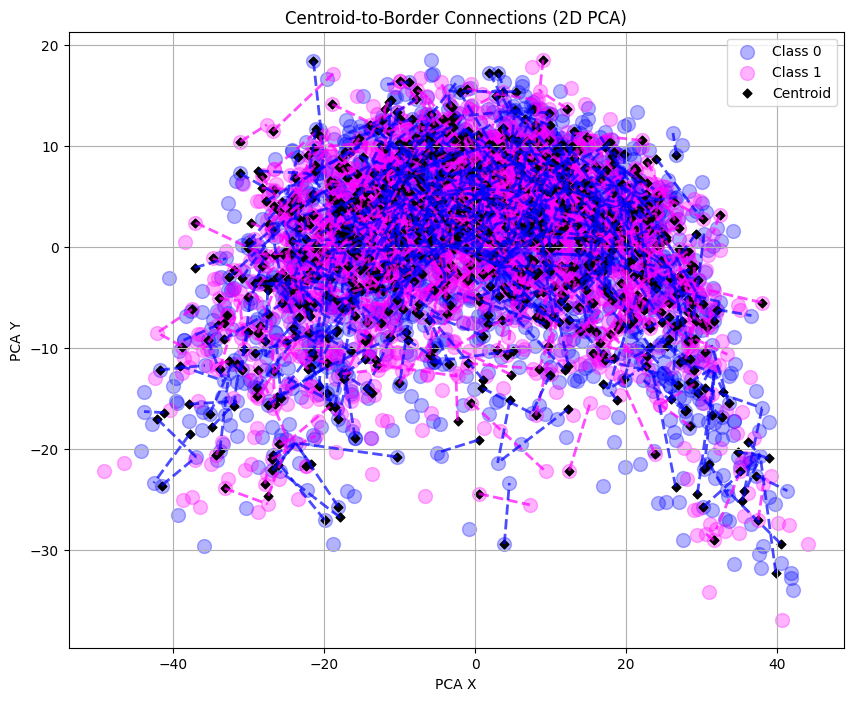

In [197]:
plot_centroids_and_borders(X, y, centroids, nearest_borders)

In [198]:
num_decision_variables = 150
size = min(len(candidate_clusters), num_decision_variables)
print(f'initial number of clusters: {len(candidate_clusters)} \nnumber of decision variables:{num_decision_variables} \nfinal size: {size}')

initial number of clusters: 1047 
number of decision variables:150 
final size: 150


In [199]:
# We select the 150 clusters with the shortest distance to their nearest border

border_dist_map = list(border_dists.items())
print(border_dist_map[:10])
border_dist_map.sort(key=lambda x: x[1])
print(border_dist_map[:10])

preselected_clusters = list(map(lambda x: x[0], border_dist_map[:size]))
preselected_centroids = {k: centroids[k] for k in preselected_clusters if k in centroids}
print(list(preselected_centroids.items())[:10])

[(6, 32.0894077561852), (34, 24.885326532326683), (38, 29.24954793661167), (84, 27.34517263491121), (94, 22.19887659282478), (129, 27.559999279915136), (167, 27.803783693426084), (215, 22.57647014262788), (227, 34.70795953601637), (254, 30.106564034539133)]
[(663, 0.0), (1291, 0.0), (3265, 0.0), (2022, 0.0), (2042, 1.9073486328125e-06), (2296, 3.3036247397782844e-06), (1745, 9.77322893469522), (2295, 11.873867467960206), (2212, 11.996190610999443), (1289, 15.205325453033792)]
[(663, array([-1.32376099, -2.98610878,  2.15662193, ...,  1.47109985,
       -0.47945979, -0.67315435])), (1291, array([-0.10424829, -3.45335102,  2.91267776, ...,  1.73073673,
       -0.3651886 , -0.28937507])), (3265, array([-0.63945961, -3.27363777,  2.01992178, ...,  0.66011357,
       -0.56241024, -1.41026974])), (2022, array([-1.0335989 , -2.06596708,  2.28908157, ...,  0.84528673,
       -0.54746246, -0.94187593])), (2042, array([-0.35697198, -2.81788635,  2.94932556, ...,  1.91504669,
       -0.66188622, 

### 5. QUBO matrix definition

* As we already did noise removal, here we are focused on removing redundancy (QUBO matrix that selects clusters likely near class boundaries)
* The key idea is to avoid selecting two clusters of the same class that are "not separated" by a border.

In [200]:
def build_qubo_matrix(
    centroids,
    centroid_border_dists,
    y,
    alpha=1.0, # penalty scaling factor --> tune
    beta=1.0, # reward scaling factor --> tune
    T=0.0, # tolerance for inner distance (hard threshold) to decide how much separation is enough to avoid redundancy--> tune
    self_bias=-0.1, # -0.1 for enhancing sparse selection
    gamma=5.0  # class balance penalty strength
):
    cluster_ids = list(centroids.keys())
    n = len(cluster_ids)
    Q = np.zeros((n, n))

    class_vector = np.array([y[cid] for cid in cluster_ids])  # class of each cluster
    w = 1 - 2 * class_vector  # w[i] = +1 for class 0, -1 for class 1
    epsilon = 1e-6  # small constant to avoid division by zero
    
    # Main reward/penalty term
    for i in range(n):
        id_i = cluster_ids[i]
        class_i = y[id_i]
        c_i = centroids[id_i]
        d_i = centroid_border_dists[id_i]
        Q[i, i] = self_bias

        for j in range(i + 1, n):
            id_j = cluster_ids[j]
            class_j = y[id_j]

            c_j = centroids[id_j]
            d_j = centroid_border_dists[id_j]

            inter_dist = np.linalg.norm(c_i - c_j)
            delta = inter_dist - (d_i + d_j + T)
            
            if class_i != class_j:
                continue

            if delta < 0:
                # Same class clusters are on the same side of a margin: penalize
                # the smaller inner distance (more redundant), the worse the penalization
                penalization = 1 / (inter_dist + epsilon)
                Q[i, j] += alpha * penalization
                Q[j, i] += alpha * penalization
            else:
                # Same class clusters are on different sides of a margin: reward
                # the closer to the margin (i.e., smaller inner distance), the better the reward
                reward = 1 / (inter_dist + epsilon)
                Q[i, j] -= beta * reward
                Q[j, i] -= beta * reward

    # Add class balance constraint: (n_0 - n_1)^2
    Q += gamma * np.outer(w, w)

    return Q, cluster_ids

In [201]:
Q, cluster_ids = build_qubo_matrix(
    preselected_centroids,
    border_dists,
    y,
    alpha=1.0,  # penalty
    beta=1.0,   # reward
    T=0.2,      # high values make it more difficult for same class rewards
    self_bias=-1.0
)

print(Q)

[[ 4.         -5.          4.98101366 ... -5.         -5.
  -5.        ]
 [-5.          4.         -5.         ...  4.98479567  4.97812646
   4.97668457]
 [ 4.98101366 -5.          4.         ... -5.         -5.
  -5.        ]
 ...
 [-5.          4.98479567 -5.         ...  4.          5.02599625
   5.02402327]
 [-5.          4.97812646 -5.         ...  5.02599625  4.
   5.03593475]
 [-5.          4.97668457 -5.         ...  5.02402327  5.03593475
   4.        ]]


### Execution

In [202]:
import dimod
from dimod import BinaryQuadraticModel

bqm = dimod.BinaryQuadraticModel.from_qubo(Q)

penalty = bqm.maximum_energy_delta() 
# Compute conservative bound on maximum change in energy when flipping a single variable.

if LIMIT_SIZE:
    num_points = K
    percentage=0.5
    combination_bqm = dimod.generators.combinations(bqm.variables, int(percentage*num_points), strength=penalty) # combinations(n: int | Collection[Hashable], k: int, strength: float = 1, ...): Generate a binary quadratic model that is minimized when k of n variables are selected.
    bqm.update(combination_bqm)

### Simulated Annealing


assert RUN_SA, "Are you sure?"

from qclef import qa_access as qa
import neal

sampler_sa = neal.SimulatedAnnealingSampler()
sampleset_sa = qa.submit(
    sampler_sa,
    neal.SimulatedAnnealingSampler.sample,
    bqm,
    label=f"{SUBMISSIONID} (SA)",
    num_reads=NUM_READS,
)
solution_sa = sampleset_sa.first.sample


### Quantum Annealing

In [203]:
assert RUN_QA, "Are you sure?"

from qclef import qa_access as qa
import neal
from dwave.system import DWaveSampler, EmbeddingComposite

sampleset_qa = qa.submit(
    EmbeddingComposite(DWaveSampler()),
    EmbeddingComposite.sample,
    bqm,
    label=f"{SUBMISSIONID} (Quantum)",
    num_reads=NUM_READS,
)

solution_qa = sampleset_qa.first.sample

SolverFailureError: There has been an error involving this submission.

In [ ]:
selected_items_SA = [i for i, v in solution_qa.items() if v == 1]
preselected_members = list(candidate_clusters.get(key) for key in preselected_clusters)

selected_members_SA = list(compress(preselected_members, selected_items_SA))
selected_cluster_ids_SA = list(compress(preselected_clusters, selected_items_SA))

print(len(selected_items_SA))


50


In [ ]:
print(selected_items_SA)
print(preselected_members)
print(selected_members_SA)
print(selected_cluster_ids_SA)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 37, 44, 47, 49, 50, 53, 54, 58, 60, 61, 62, 70, 76, 77, 78, 79, 83, 85, 87, 88, 89, 90, 92, 93, 95, 100, 104, 105, 110, 115, 120, 121, 123, 131, 138, 143, 145, 147]
[[663], [1291], [3265], [2022], [2042], [2296], [1745], [2297, 2295], [2665, 2212], [1289, 348], [840, 844, 1631], [3795, 2917, 2326], [329, 1910], [2833, 2491, 3759], [3552, 273, 3180, 361], [3680, 326, 1482, 2352, 2938], [2021, 2805], [89, 2929, 1916, 1487], [1336, 2345, 2646], [2240, 1122, 3405], [3681, 1168, 2385, 2259, 1331, 477], [986, 1028, 95, 1255], [672, 3473, 3278], [3018, 2411, 2798], [1899, 2670, 113, 1011, 723, 341], [1202, 3722, 3091, 974], [2276, 2384, 979, 765, 767], [424, 1213, 2693], [2764, 3950, 537, 3705, 3386], [2904, 2626, 1335], [2266, 887], [3069], [2866, 29, 2962], [212, 2981], [1347, 2164, 3454, 1310], [2528, 1322, 2533, 1439], [1530, 3764, 3319], [1098, 3237], [664, 2195, 3853, 662], [3023, 3709, 3711], [1796, 1037, 1142], [264, 3601, 3248, 1983], [2887, 349

In [ ]:
print(f"Best solution: {solution_sa}")
print(f"Selected clusters: {selected_members_SA}")

selected_instances_SA = []
for members in selected_members_SA:
    selected_instances_SA = selected_instances_SA + members

print(f"Selected instances: {selected_instances_SA}")

submission_documents = []
submission_documents = selected_instances_SA + borders_lsbo
print(f"Selected instances including borders ({len(submission_documents)}): {submission_documents}")

Best solution: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 1, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 1, 45: 0, 46: 0, 47: 1, 48: 0, 49: 1, 50: 1, 51: 0, 52: 0, 53: 1, 54: 1, 55: 0, 56: 0, 57: 0, 58: 1, 59: 0, 60: 1, 61: 1, 62: 1, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 1, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 1, 77: 1, 78: 1, 79: 1, 80: 0, 81: 0, 82: 0, 83: 1, 84: 0, 85: 1, 86: 0, 87: 1, 88: 1, 89: 1, 90: 1, 91: 0, 92: 1, 93: 1, 94: 0, 95: 1, 96: 0, 97: 0, 98: 0, 99: 0, 100: 1, 101: 0, 102: 0, 103: 0, 104: 1, 105: 1, 106: 0, 107: 0, 108: 0, 109: 0, 110: 1, 111: 0, 112: 0, 113: 0, 114: 0, 115: 1, 116: 0, 117: 0, 118: 0, 119: 0, 120: 1, 121: 1, 122: 0, 123: 1, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 1, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0

In [ ]:
def plot_selected_instances(X, y, clusters, selected_cluster_ids, borders, noise=None):
    num_points = len(X)

    # Gather selected (non-border) points
    selected_points = set()
    for cid in selected_cluster_ids:
        selected_points.update(clusters[cid])
    selected_points = selected_points - set(borders)
    selected_points = np.array(sorted(selected_points))

    if noise is None:
        noise = []
    noise = np.array(noise)
    borders = np.array(borders)

    print(f"Selected cluster points (non-borders): {len(selected_points)}")
    print(f"Border points: {len(borders)}")
    print(f"Noise points: {len(noise)}")

    # Prepare points for PCA
    all_indices = np.unique(np.concatenate([np.arange(num_points), selected_points, borders, noise]))
    X_subset = X[all_indices]
    y_subset = y[all_indices]

    # Project with PCA
    pca = PCA(n_components=2)
    X_proj = pca.fit_transform(X_subset)

    # Mapping from original indices to projected positions
    index_map = {orig_idx: proj_idx for proj_idx, orig_idx in enumerate(all_indices)}

    colors = ['blue', 'green', 'red', 'orange', 'magenta']

    plt.figure(figsize=(10, 8))

    for i in range(2):  # Assuming binary classification
        class_indices = [index_map[idx] for idx in all_indices if y[idx] == i]
        plt.scatter(X_proj[class_indices, 0], X_proj[class_indices, 1],
                    label=f'Class {i}', alpha=0.3, color=colors[i], s=50)       

        # Border points (triangles)
        border_mask = [index_map[idx] for idx in borders if y[idx] == i and idx in index_map]
        plt.scatter(X_proj[border_mask, 0], X_proj[border_mask, 1],
                    alpha=0.9, color=colors[i+2], marker='^', s=20, label=f'Borders Class {i}')

        # Selected points (stars)
        selected_mask = [index_map[idx] for idx in selected_points if y[idx] == i and idx in index_map]
        plt.scatter(X_proj[selected_mask, 0], X_proj[selected_mask, 1],
                    alpha=1, color=colors[i], marker='*', s=50, label=f'Selected Class {i}')

    # Noise points (cross)
    if len(noise) > 0:
        noise_mask = [index_map[idx] for idx in noise if idx in index_map]
        plt.scatter(X_proj[noise_mask, 0], X_proj[noise_mask, 1], color='black', marker='x', s=50, label='Noise')

    plt.xlabel('PCA X')
    plt.ylabel('PCA Y')
    plt.title('Selected Instances (2D PCA)')
    plt.legend()
    plt.grid(True)
    plt.show()


Selected cluster points (non-borders): 148
Border points: 1806
Noise points: 385


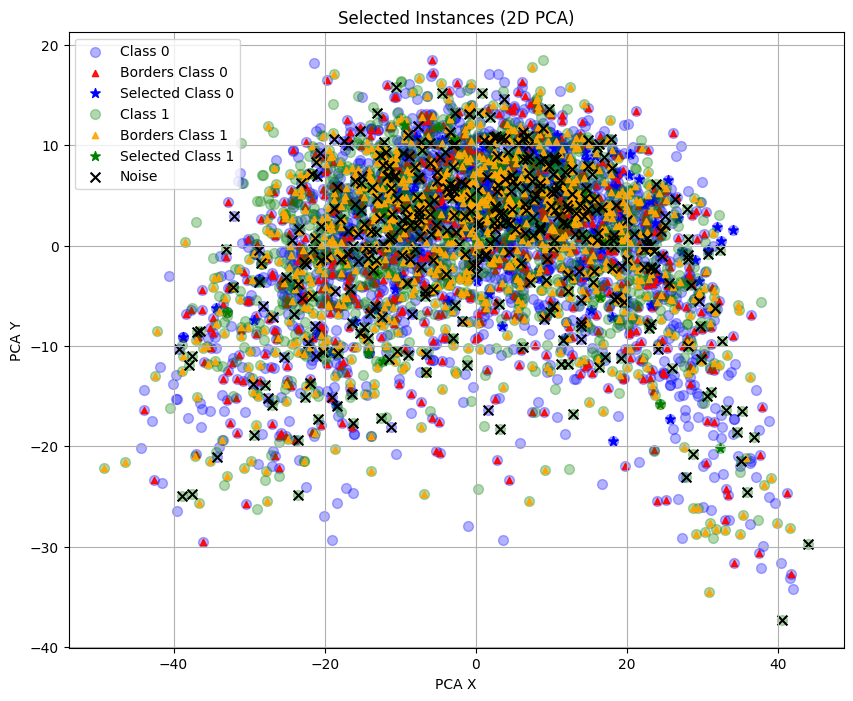

In [ ]:
plot_selected_instances(X, y, clusters_inverse, selected_cluster_ids_SA, borders_lsbo, noise_indices)

### Build submit

In [ ]:
def submit(docs_to_keep, ids, dataset_name, fold_number, method_type, group_name, submission_id):
    """
    Summits the results of the instance selection process to the specified file.

    Parameters:
    - dataset_name: str
        Name of the dataset.
    - fold_number: int
        Fold number used in the feature selection process.
    - method_type: str
        Type of the method used for feature selection (SA, QA).
    - group_name: str
        Name of the group or team.
    - submission_id: str
        Custom ID representing the submission.
    """
    # Create the submission filename
    filename = f"{dataset_name}_{fold_number}_{method_type}_{group_name}_{submission_id}.txt"

    submission = ""
    for i, doc in enumerate(docs_to_keep): 
        submission += str(doc) + "\n"
    submission+=str(ids)
    
    # Write the submission to a file
    with open(filename, "w") as f:
        f.write(submission)
    
    print(f"Submission written to {filename}")

In [ ]:
ids_sa = [
    sampleset_sa.info["problem_id"]
]  # The ids of the solved problems that relate to this given submission.

submit(submission_documents
        , ids_sa
        , DATASET_NAME
        , FOLD
        , "SA"
        , TEAM_NAME
        , f"{SUBMISSIONID}(docs=just-final,reads={NUM_READS},limit={LIMIT_SIZE})")



Submission written to Yelp_4_SA_gplsi_2-LocalSets(docs=just-final,reads=2000,limit=False).txt
